# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


import sys
import os
# add library module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../")

from dtreeviz import trees
from dtreeviz.models.lightgbm_decision_tree import ShadowLightGBMTree


# Load and prepare dataset

In [9]:
dataset = pd.read_csv("../data/titanic/titanic.csv")

In [10]:
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [11]:
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)
# Encode categorical variables
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes
dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes

# Classification

## Datasets

In [12]:
features = ["Pclass", "Sex_label", "Embarked_label", "Age", "Cabin_label", "Fare"]
target = "Survived"

X_train, X_test, y_train, y_test = train_test_split(dataset[features], dataset[target], test_size=0.2, random_state=42)

train_data = lgb.Dataset(data=X_train, label=y_train, feature_name=features, categorical_feature=["Sex_label", "Pclass", "Embarked_label", "Cabin_label"])
valid_data = lgb.Dataset(data=X_test, label=y_test, feature_name=features, categorical_feature=["Sex_label", "Pclass", "Embarked_label", "Cabin_label"])


## Model training

In [13]:
lgbm_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 22,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'drop_rate': 0.15,
    'max_depth':4,
    "seed":1212}

lgbm_model = lgb.train(lgbm_params, train_data, valid_sets=[train_data, valid_data])

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's binary_logloss: 0.65258	valid_1's binary_logloss: 0.669903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's binary_logloss: 0.643893	valid_1's binary_logloss: 0.659912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's binary_logloss: 0.636543	valid_1's binary_logloss: 0.652435
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/tudorl/Documents/workspace/personal/dtreeviz/venv/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/tudorl/Documents/workspace/personal/dtreeviz/venv/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/tudorl/Documents/workspace/personal/dtreeviz/venv/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


## LightGBM default visualisations

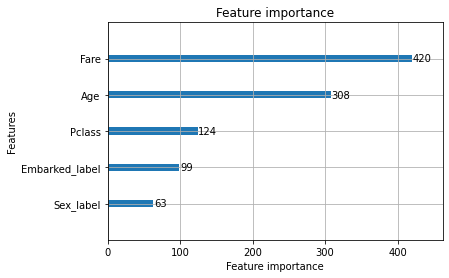

In [14]:
lgb.plot_importance(lgbm_model)

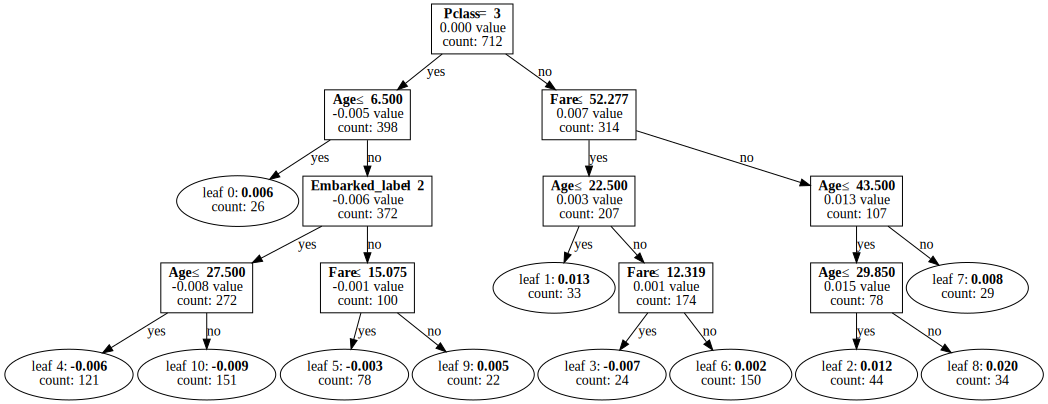

In [15]:
lgb.create_tree_digraph(lgbm_model, tree_index=1,  orientation = "vertical", show_info=['internal_count', 'leaf_count', 'internal_value'])


## dtreeviz visualizations

In [16]:
# lgbm_model.save_model("../testing/dtreeviz/models/fixtures/lightgbm_model_classifier.txt")
# lgbm = lgb.Booster(model_file="../testing/dtreeviz/models/fixtures/lightgbm_model_classifier.txt")

In [17]:
light_dtree = ShadowLightGBMTree(lgbm_model, tree_index=1, x_data=X_train, y_data=y_train, feature_names=features, target_name=target, class_names=[0,1] )


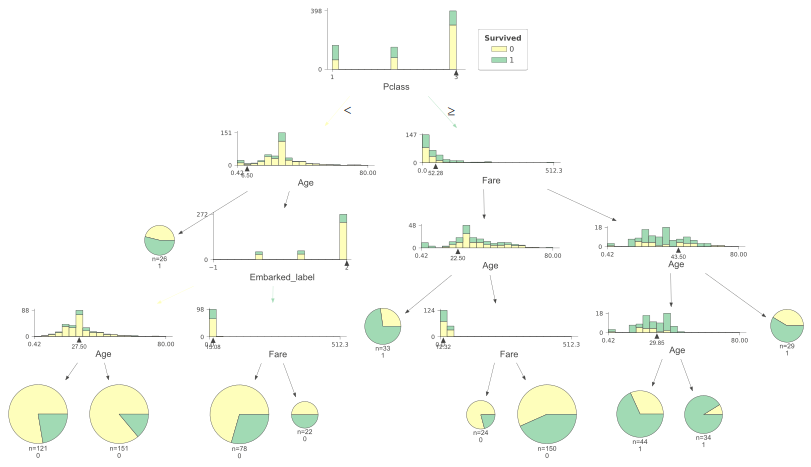

In [18]:
trees.dtreeviz(light_dtree)

Pclass             3.000
Sex_label          1.000
Embarked_label     2.000
Age               32.000
Cabin_label       -1.000
Fare               7.925
Name: 382, dtype: float64


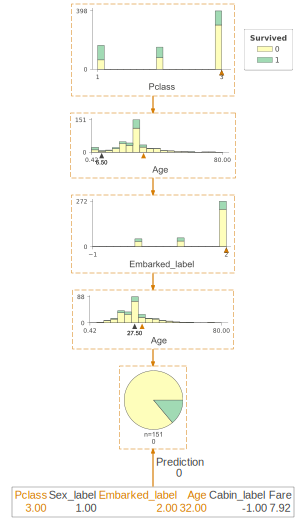

In [19]:
x = X_train[features].iloc[2]
print(x)
trees.dtreeviz(light_dtree, X=x, show_just_path=True)

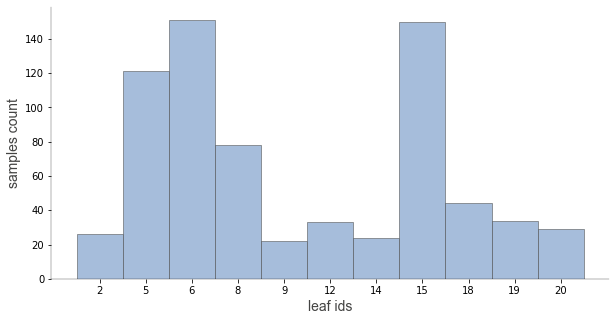

In [16]:
trees.viz_leaf_samples(light_dtree)

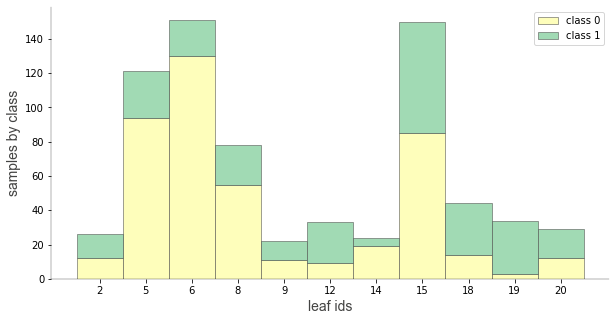

In [17]:
trees.ctreeviz_leaf_samples(light_dtree)

In [18]:
trees.describe_node_sample(light_dtree, node_id=5)

,Pclass,Sex_label,Embarked_label,Age,Cabin_label,Fare
count,121.0,121.000000,121.0,121.000000,121.000000,121.000000
mean,3.0,0.710744,2.0,20.417355,3.520661,12.499723
std,0.0,0.455302,0.0,4.735657,24.624886,10.342666
min,3.0,0.000000,2.0,7.000000,-1.000000,0.000000
25%,3.0,0.000000,2.0,18.000000,-1.000000,7.795800
50%,3.0,1.000000,2.0,21.000000,-1.000000,8.050000
75%,3.0,1.000000,2.0,24.000000,-1.000000,10.170800
max,3.0,1.000000,2.0,27.000000,145.000000,56.495800


In [19]:
x = X_train[features].iloc[10]
x

Pclass             2.0
Sex_label          0.0
Embarked_label     2.0
Age               42.0
Cabin_label       -1.0
Fare              13.0
Name: 865, dtype: float64

In [20]:
print(trees.explain_prediction_path(light_dtree, x=x))

22.5 <= Age 
12.32 <= Fare  < 52.28
Pclass in [] 



# Regression

## Datasets

In [37]:
features_reg = ["Pclass", "Survived", "Sex_label", "Cabin_label", "Embarked_label"]
target_reg = "Age"

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(dataset[features_reg], dataset[target_reg], test_size=0.2, random_state=42)

# categorical_feature=["Pclass", "Survived", "Sex_label", "Embarked_label", "Cabin_label"]
train_data_reg = lgb.Dataset(data=X_train_reg, label=y_train_reg, categorical_feature=["Pclass", "Survived", "Sex_label", "Embarked_label", "Cabin_label"])
valid_data_reg = lgb.Dataset(data=X_test_reg, label=y_test_reg, categorical_feature=["Pclass", "Survived", "Sex_label", "Embarked_label", "Cabin_label"])

lgbm_params = {
    'num_tree':10,
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'regression_l1',     
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'drop_rate': 0.15,
    'max_depth':4,
    "seed":1212}


## Model training

In [38]:
lgbm_reg_model = lgb.train(lgbm_params, train_data_reg, valid_sets=[train_data_reg, valid_data_reg])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 5
[LightGBM] [Info] Start training from score 29.699118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l1: 9.05112	valid_1's l1: 9.06394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l1: 9.027	valid_1's l1: 9.05478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l1: 9.00439	valid_1's l1: 9.04684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l1: 9.00495	valid_1's l1: 9.04704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's l1: 9.00016

/Users/tudorl/Documents/workspace/personal/dtreeviz/venv/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_tree` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/tudorl/Documents/workspace/personal/dtreeviz/venv/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/tudorl/Documents/workspace/personal/dtreeviz/venv/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/tudorl/Documents/workspace/personal/dtreeviz/venv/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


## LightGBM default visualisations

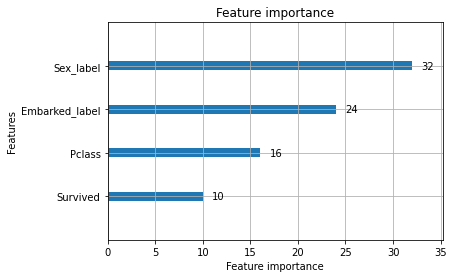

In [39]:
lgb.plot_importance(lgbm_reg_model)

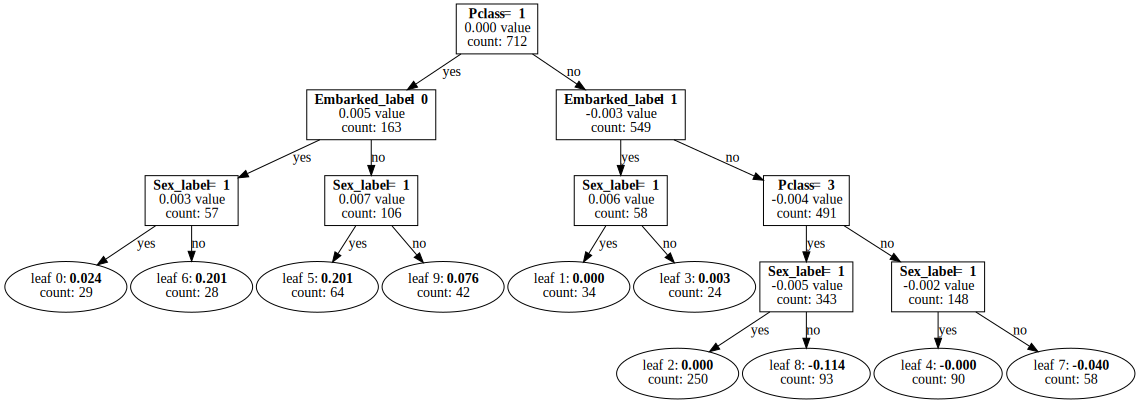

In [40]:
lgb.create_tree_digraph(lgbm_reg_model, tree_index=1,  orientation = "vertical", show_info=['internal_count', 'leaf_count', 'internal_value'])


## dtreeviz visualisations

In [41]:
light_dtree_reg = ShadowLightGBMTree(lgbm_reg_model, tree_index=1, x_data=X_train_reg, y_data=y_train_reg, feature_names=features_reg, target_name=target_reg)


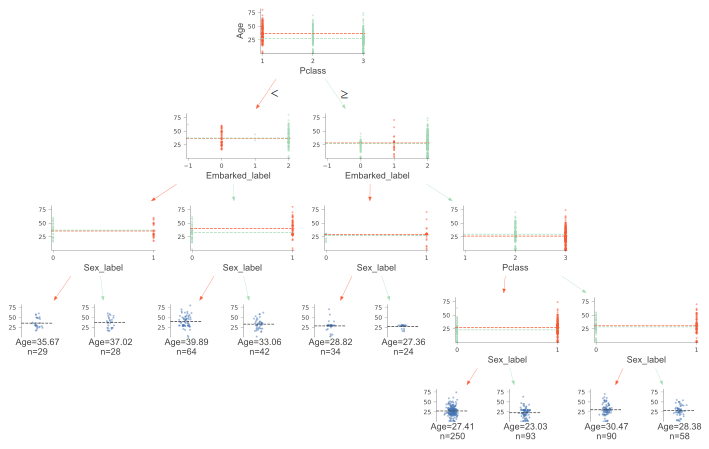

In [45]:
trees.dtreeviz(light_dtree_reg, show_node_labels=False)

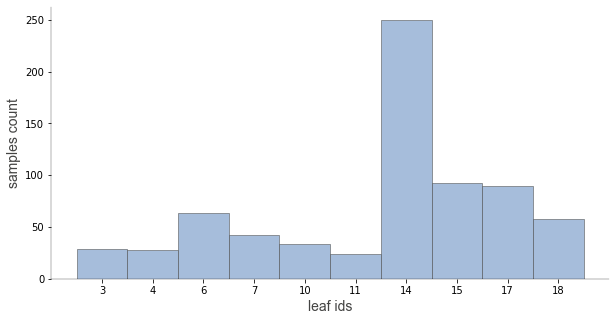

In [46]:
trees.viz_leaf_samples(light_dtree_reg)

In [35]:
trees.describe_node_sample(light_dtree_reg, node_id=14)

,Pclass,Survived,Sex_label,Cabin_label,Embarked_label
count,250.0,250.000000,250.0,250.00000,250.000000
mean,3.0,0.148000,1.0,1.62800,1.720000
std,0.0,0.355812,0.0,18.50349,0.695366
min,3.0,0.000000,1.0,-1.00000,0.000000
25%,3.0,0.000000,1.0,-1.00000,2.000000
50%,3.0,0.000000,1.0,-1.00000,2.000000
75%,3.0,0.000000,1.0,-1.00000,2.000000
max,3.0,1.000000,1.0,140.00000,2.000000


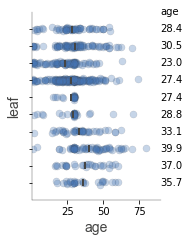

In [30]:
trees.viz_leaf_target(light_dtree_reg)

In [137]:
x = X_train_reg[features_reg].iloc[20]
x

Pclass             3.000
Survived           0.000
Fare              31.275
Sex_label          0.000
Cabin_label       -1.000
Embarked_label     2.000
Name: 542, dtype: float64

/Users/tudorl/Documents/workspace/personal/dtreeviz/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tudorl/Documents/workspace/personal/dtreeviz/venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


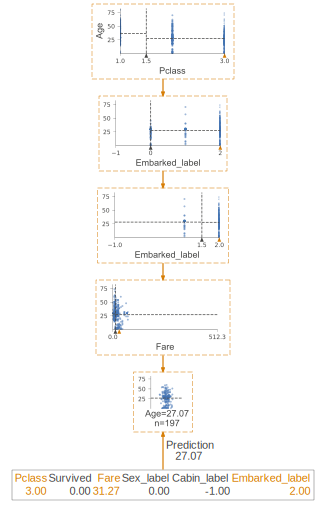

In [138]:
trees.dtreeviz(light_dtree_reg, X=x, show_just_path=True)

In [139]:
print(trees.explain_prediction_path(light_dtree_reg, x))

1.5 <= Pclass 
12.5 <= Fare 
1.5 <= Embarked_label 

